# Calculate titers of RBD mutant spike-pseudotyped lentiviruses

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
pd.read_csv('data/virus_titer_RLU/ACE2clones_Wu_1_RLU.csv')

,plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells
0,2800,rep1,Wuhan1_614G,0.250000,25.000000,4085192,241021,293T_consensus_kozak
1,2800,rep1,Wuhan1_614G,0.125000,12.500000,613486,241021,293T_consensus_kozak
2,2800,rep1,Wuhan1_614G,0.062500,6.250000,128746,241021,293T_consensus_kozak
3,2800,rep1,Wuhan1_614G,0.031250,3.125000,45646,241021,293T_consensus_kozak
4,2800,rep1,Wuhan1_614G,0.015625,1.562500,24070,241021,293T_consensus_kozak
...,...,...,...,...,...,...,...,...
111,2800,rep2,Wuhan1_614G,0.003906,0.390625,6673,241021,293T_ACE2_Clone_G
112,2800,rep2,Wuhan1_614G,0.001953,0.195312,5191,241021,293T_ACE2_Clone_G
113,2800,rep2,Wuhan1_614G,0.000977,0.097656,2915,241021,293T_ACE2_Clone_G
114,2800,rep2,Wuhan1_614G,0.000488,0.048828,1228,241021,293T_ACE2_Clone_G


In [6]:
titers = pd.read_csv(config['virus_titers'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,RLUperuL
2800,rep1,Wuhan1_614G,0.250000,25.0000,4085192,241021,293T_consensus_kozak,163407.68
2800,rep1,Wuhan1_614G,0.125000,12.5000,613486,241021,293T_consensus_kozak,49078.88
2800,rep1,Wuhan1_614G,0.062500,6.2500,128746,241021,293T_consensus_kozak,20599.36
2800,rep1,Wuhan1_614G,0.031250,3.1250,45646,241021,293T_consensus_kozak,14606.72
2800,rep1,Wuhan1_614G,0.015625,1.5625,24070,241021,293T_consensus_kozak,15404.80


Saving to results/RLU-vs-uL.pdf


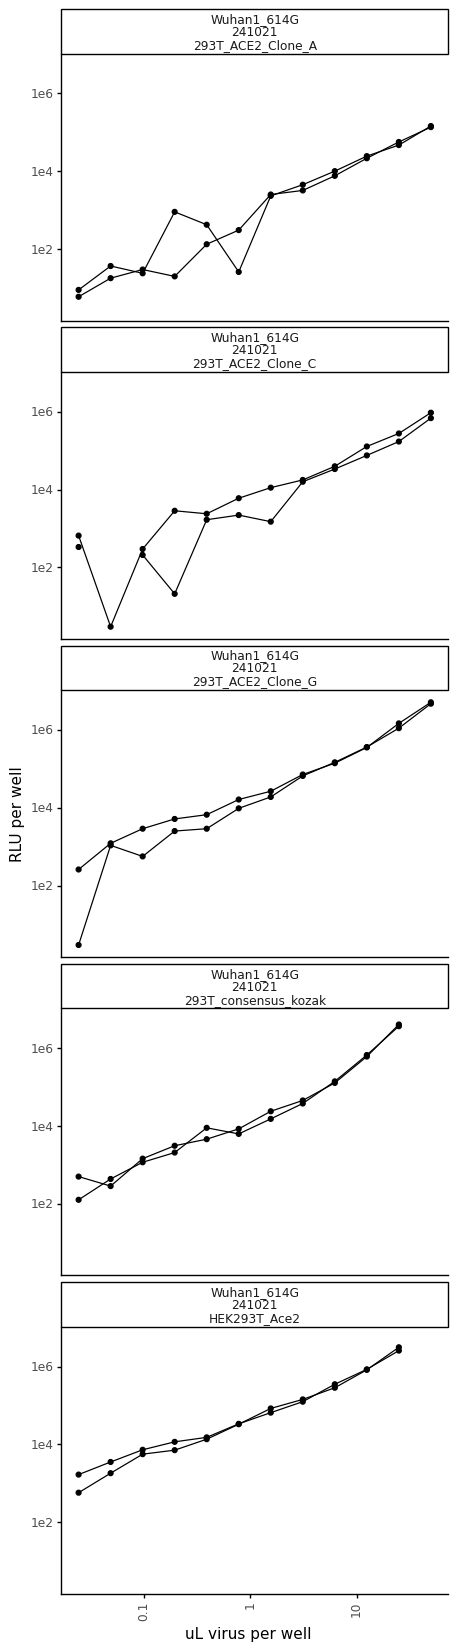

In [7]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells', ncol=ncol) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(5 * ncol, 20 * nrow),
           )
     )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'RLU-vs-uL.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/RLUperuL.pdf


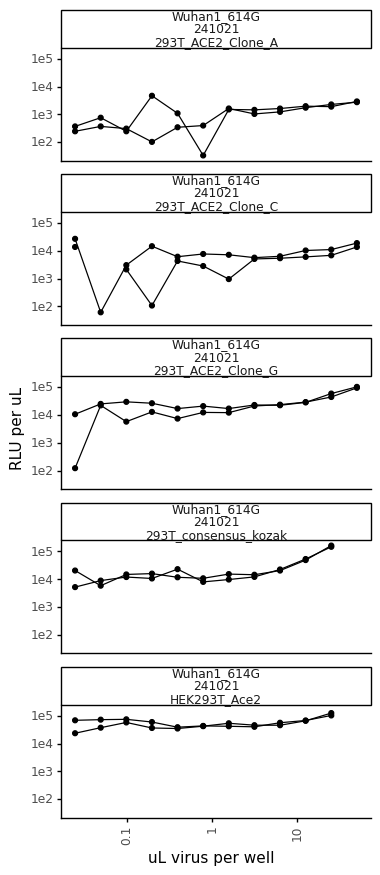

In [8]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells', ncol=ncol) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(4 * ncol, 10 * nrow),
           ) 
     )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'RLUperuL.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

From visual inspection of the above plots, it appears that only the 6 highest dilutions (i.e., >1.5uL of virus per well) are reliable enough to calculate titers. 

In [9]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,replicate,date,cells,mean_RLUperuL
Wuhan1_614G,rep1,241021,293T_ACE2_Clone_A,1771.266667
Wuhan1_614G,rep1,241021,293T_ACE2_Clone_C,6343.790000
Wuhan1_614G,rep1,241021,293T_ACE2_Clone_G,37624.700000
Wuhan1_614G,rep1,241021,293T_consensus_kozak,52619.488000
Wuhan1_614G,rep1,241021,HEK293T_Ace2,67143.120000


Saving to results/virus_titers.pdf


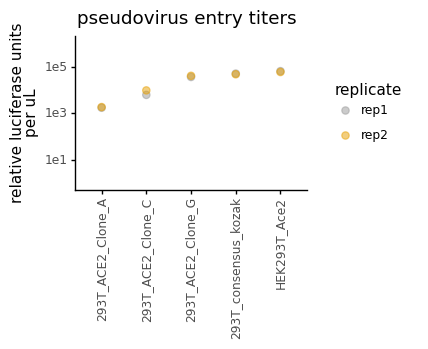

In [10]:
p = (ggplot(average_titers, 
            aes(x='cells', y='mean_RLUperuL', color='replicate')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*3,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[1,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_color_manual(values=CBPALETTE)
    )

_ = p.draw()

plotfile = os.path.join(resultsdir, 'virus_titers.pdf')
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Calculate how much virus to use in neut assays:

In [11]:
target_RLU = 2e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date', 'cells'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_8mL = lambda x: 8000/x['dilution_factor'],
                        media_for_8ml = lambda x: 8000 - 8000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.head().to_html(index=False)))

Saving to results/virus_titers.csv


virus,date,cells,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_8mL,media_for_8ml
Wuhan1_614G,241021,293T_ACE2_Clone_A,1830.921667,200000.0,50,0.457730,17477.536359,-9477.536359
Wuhan1_614G,241021,293T_ACE2_Clone_C,8123.145000,200000.0,50,2.030786,3939.360925,4060.639075
Wuhan1_614G,241021,293T_ACE2_Clone_G,39923.311667,200000.0,50,9.980828,801.536713,7198.463287
Wuhan1_614G,241021,293T_consensus_kozak,50877.348000,200000.0,50,12.719337,628.963601,7371.036399
Wuhan1_614G,241021,HEK293T_Ace2,64376.044000,200000.0,50,16.094011,497.079317,7502.920683


In [12]:
# !jupyter nbconvert calculate_titer.ipynb --to HTML